# **3) Model 1**

In [6]:
import os
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lit, pandas_udf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Preprocessing for #1:

### Chunking Data into Timeframes

In [5]:
spark = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.instances", 7) \
    .getOrCreate()

schema = StructType([
    StructField("subject", StringType()),
    StructField("modality", StringType()),
    StructField("label", IntegerType()),
    StructField("mean", FloatType()),
    StructField("std", FloatType()),
    StructField("min", FloatType()),
    StructField("max", FloatType())
])

@pandas_udf(schema, functionType=PandasUDFType.GROUPED_MAP)
def chunk_and_compute_stats_udf(pdf):
    pdf = pdf.sort_values("sample")
    signal_values = pdf.drop(columns=["subject", "label", "sample", "modality"]).values
    labels = pdf["label"].values

    chunk_size = 1000
    total_chunks = len(labels) // chunk_size
    if total_chunks == 0:
        return pd.DataFrame(columns=["subject", "modality", "label", "mean", "std", "min", "max"])

    signal_values = signal_values[:total_chunks * chunk_size].reshape(total_chunks, chunk_size, -1)
    label_chunks = labels[:total_chunks * chunk_size].reshape(total_chunks, chunk_size)

    stats_rows = []
    for i in range(total_chunks):
        window = signal_values[i]
        majority_label = mode(label_chunks[i], keepdims=False).mode

        for j in range(window.shape[1]):
            stats_rows.append({
                "subject": pdf['subject'].iloc[0],
                "modality": pdf['modality'].iloc[0],
                "label": int(majority_label),
                "mean": float(np.mean(window[:, j])),
                "std": float(np.std(window[:, j])),
                "min": float(np.min(window[:, j])),
                "max": float(np.max(window[:, j]))
            })

    return pd.DataFrame(stats_rows)

In [6]:
modality_files = [
    "df_chest_ecg.csv",
    "df_chest_emg.csv",
    "df_chest_eda.csv",
    "df_chest_temp.csv",
    "df_chest_resp.csv",
    "df_wrist_bvp.csv",
    "df_wrist_eda.csv",
    "df_wrist_temp.csv"
]

data_dir = "../msawires1/combined_pkl_csv"
all_chunks = []

for file in modality_files:
    file_path = os.path.join(data_dir, file)
    if os.path.exists(file_path):
        modality = file.replace("df_", "").replace(".csv", "")
        print(f"Processing {modality}...")
        
        df = spark.read.csv(file_path, header=True, inferSchema=True)
        df = df.withColumn("modality", lit(modality))
        chunked_df = df.groupBy("subject").apply(chunk_and_compute_stats_udf)
        all_chunks.append(chunked_df)
    else:
        print(f"File not found: {file_path}")

# Union all Spark DataFrames
final_df = all_chunks[0]
for df in all_chunks[1:]:
    final_df = final_df.union(df)

final_df.show()

Processing chest_ecg...


/usr/local/spark/python/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Processing chest_emg...
Processing chest_eda...
Processing chest_temp...
Processing chest_resp...
Processing wrist_bvp...
Processing wrist_eda...
Processing wrist_temp...
+-------+---------+-----+-------------+-----------+-----------+----------+
|subject| modality|label|         mean|        std|        min|       max|
+-------+---------+-----+-------------+-----------+-----------+----------+
|    S10|chest_ecg|    1|   0.01168753|0.122706525| -0.4182129|0.63468933|
|    S10|chest_ecg|    1| 0.0039809877| 0.15130818| -0.5663452| 0.7858429|
|    S10|chest_ecg|    1|  0.005229355| 0.14567506|-0.65812683| 0.7099457|
|    S10|chest_ecg|    1| 0.0028832245| 0.12549666|-0.66389465|0.61335754|
|    S10|chest_ecg|    1|-0.0035272979|0.120900325|-0.46110535|0.43327332|
|    S10|chest_ecg|    1| -0.006145569| 0.12726215| -0.5454712| 0.6622925|
|    S10|chest_ecg|    1| 0.0030956727| 0.12389012| -0.5771942|0.68096924|
|    S10|chest_ecg|    1|  0.005852371| 0.11291345|-0.40663147| 0.5336151|
|   

In [7]:
final_df.printSchema()

root
 |-- subject: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- mean: float (nullable = true)
 |-- std: float (nullable = true)
 |-- min: float (nullable = true)
 |-- max: float (nullable = true)



### Adding PANAS Questionnaire Data

In [8]:
questionnaire_df = spark.read.csv("all_questionnaires.csv", header=True, inferSchema=True)

In [9]:
questionnaire_df.show(5)
questionnaire_df.printSchema()

+----------+------------+--------------+------------+----------------+----------------+--------------+-------------+------------+------------+------------+-------------+-------------+-----------+---------------+------------------+-------------+-----------+-------------+----------------+---------------+-------------+------------+--------------+----------------+-----------+---------+-------------------+-------------------+-----------------+-----------------+-----------------+--------------------+-----------+-----------+-----------------------+----------------------+--------------+-------------------------+-------------------------+-------------------------------+
|subject_id|condition_id|condition_name|panas_active|panas_distressed|panas_interested|panas_inspired|panas_annoyed|panas_strong|panas_guilty|panas_scared|panas_hostile|panas_excited|panas_proud|panas_irritable|panas_enthusiastic|panas_ashamed|panas_alert|panas_nervous|panas_determined|panas_attentive|panas_jittery|panas_afraid|

In [10]:
questionnaire_df = questionnaire_df.withColumnRenamed("condition_id", "label")

In [11]:
questionnaire_df = questionnaire_df.withColumnRenamed("subject_id", "subject")

In [12]:
questionnaire_df.printSchema()

root
 |-- subject: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- condition_name: string (nullable = true)
 |-- panas_active: integer (nullable = true)
 |-- panas_distressed: integer (nullable = true)
 |-- panas_interested: integer (nullable = true)
 |-- panas_inspired: integer (nullable = true)
 |-- panas_annoyed: integer (nullable = true)
 |-- panas_strong: integer (nullable = true)
 |-- panas_guilty: integer (nullable = true)
 |-- panas_scared: integer (nullable = true)
 |-- panas_hostile: integer (nullable = true)
 |-- panas_excited: integer (nullable = true)
 |-- panas_proud: integer (nullable = true)
 |-- panas_irritable: integer (nullable = true)
 |-- panas_enthusiastic: integer (nullable = true)
 |-- panas_ashamed: integer (nullable = true)
 |-- panas_alert: integer (nullable = true)
 |-- panas_nervous: integer (nullable = true)
 |-- panas_determined: integer (nullable = true)
 |-- panas_attentive: integer (nullable = true)
 |-- panas_jittery: integer (null

In [13]:
final_df = final_df.join(questionnaire_df, on=["subject", "label"], how="left")

In [14]:
#redefine final_df to include self report dat
final_df.printSchema()

root
 |-- subject: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- modality: string (nullable = true)
 |-- mean: float (nullable = true)
 |-- std: float (nullable = true)
 |-- min: float (nullable = true)
 |-- max: float (nullable = true)
 |-- condition_name: string (nullable = true)
 |-- panas_active: integer (nullable = true)
 |-- panas_distressed: integer (nullable = true)
 |-- panas_interested: integer (nullable = true)
 |-- panas_inspired: integer (nullable = true)
 |-- panas_annoyed: integer (nullable = true)
 |-- panas_strong: integer (nullable = true)
 |-- panas_guilty: integer (nullable = true)
 |-- panas_scared: integer (nullable = true)
 |-- panas_hostile: integer (nullable = true)
 |-- panas_excited: integer (nullable = true)
 |-- panas_proud: integer (nullable = true)
 |-- panas_irritable: integer (nullable = true)
 |-- panas_enthusiastic: integer (nullable = true)
 |-- panas_ashamed: integer (nullable = true)
 |-- panas_alert: integer (nullable = true)

In [15]:
num_rows = final_df.count()
num_cols = len(final_df.columns)
print(f"Shape: ({num_rows}, {num_cols})")

Shape: (160518, 46)


In [16]:
summary = final_df.groupBy("subject", "label").count()
summary.show()

+-------+-----+-----+
|subject|label|count|
+-------+-----+-----+
|    S10|    1| 4223|
|    S10|    3| 1328|
|    S10|    2| 2597|
|    S10|    4| 2825|
|     S6|    4| 2789|
|     S6|    3| 1327|
|     S6|    1| 4223|
|     S6|    2| 2324|
|     S8|    2| 2396|
|     S8|    1| 4182|
|     S8|    4| 2827|
|     S8|    3| 1323|
|     S7|    4| 2803|
|     S7|    3| 1333|
|     S7|    1| 4243|
|     S7|    2| 2289|
|     S4|    4| 2868|
|     S4|    2| 2268|
|     S4|    1| 4146|
|     S4|    3| 1328|
+-------+-----+-----+
only showing top 20 rows



In [17]:
print(final_df.columns)

['subject', 'label', 'modality', 'mean', 'std', 'min', 'max', 'condition_name', 'panas_active', 'panas_distressed', 'panas_interested', 'panas_inspired', 'panas_annoyed', 'panas_strong', 'panas_guilty', 'panas_scared', 'panas_hostile', 'panas_excited', 'panas_proud', 'panas_irritable', 'panas_enthusiastic', 'panas_ashamed', 'panas_alert', 'panas_nervous', 'panas_determined', 'panas_attentive', 'panas_jittery', 'panas_afraid', 'panas_stressed', 'panas_frustrated', 'panas_happy', 'panas_sad', 'stai_i_feel_at_ease', 'stai_i_feel_nervous', 'stai_i_am_jittery', 'stai_i_am_relaxed', 'stai_i_am_worried', 'stai_i_feel_pleasant', 'sam_valence', 'sam_arousal', 'sssq_committed_to_goals', 'sssq_wanted_to_succeed', 'sssq_motivated', 'sssq_reflected_about_self', 'sssq_worried_about_others', 'sssq_concerned_about_impression']


In [18]:
#convert to pandas for ML
final_df = final_df.toPandas()

In [19]:
final_df.head(5)

,subject,label,modality,mean,std,min,max,condition_name,panas_active,panas_distressed,...,stai_i_am_worried,stai_i_feel_pleasant,sam_valence,sam_arousal,sssq_committed_to_goals,sssq_wanted_to_succeed,sssq_motivated,sssq_reflected_about_self,sssq_worried_about_others,sssq_concerned_about_impression
0,S10,1,chest_ecg,0.011688,0.122707,-0.418213,0.634689,baseline,2,1,...,1,2,6,2,NaN,NaN,NaN,NaN,NaN,NaN
1,S10,1,chest_ecg,0.003981,0.151308,-0.566345,0.785843,baseline,2,1,...,1,2,6,2,NaN,NaN,NaN,NaN,NaN,NaN
2,S10,1,chest_ecg,0.005229,0.145675,-0.658127,0.709946,baseline,2,1,...,1,2,6,2,NaN,NaN,NaN,NaN,NaN,NaN
3,S10,1,chest_ecg,0.002883,0.125497,-0.663895,0.613358,baseline,2,1,...,1,2,6,2,NaN,NaN,NaN,NaN,NaN,NaN
4,S10,1,chest_ecg,-0.003527,0.120900,-0.461105,0.433273,baseline,2,1,...,1,2,6,2,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Label distribution
print("Label distribution:")
print(final_df['label'].value_counts(normalize=True))

# Basic stats per label
print("\nMean statistics per label:")
print(final_df.groupby('label').mean(numeric_only=True))

# Check for NaNs or weird values
print("\nMissing values:")
print(final_df.isnull().sum())

Label distribution:
label
1    0.392672
4    0.261167
2    0.222069
3    0.124092
Name: proportion, dtype: float64

Mean statistics per label:
           mean       std       min        max  panas_active  \
label                                                          
1      7.360125  1.193495  3.391013  11.054914      1.531278   
2      7.885391  1.545908  2.744271  12.818792      2.732396   
3      7.577632  1.275973  3.274309  11.551105      2.944174   
4      7.689933  0.911904  4.572257  10.587931      1.201756   

       panas_distressed  panas_interested  panas_inspired  panas_annoyed  \
label                                                                      
1              1.132125          3.532897        2.132363       1.065777   
2              1.454048          3.586153        3.139539       1.190765   
3              1.734374          2.938300        2.396405       1.668959   
4              1.199442          2.262201        1.800153       1.135490   

       panas_st

In [23]:
# Remove NaN 
final_df = final_df.dropna(axis=1)

In [24]:
# Check for NaNs or weird values
print("\nMissing values:")
print(final_df.isnull().sum())


Missing values:
subject                 0
label                   0
modality                0
mean                    0
std                     0
min                     0
max                     0
condition_name          0
panas_active            0
panas_distressed        0
panas_interested        0
panas_inspired          0
panas_annoyed           0
panas_strong            0
panas_guilty            0
panas_scared            0
panas_hostile           0
panas_excited           0
panas_proud             0
panas_irritable         0
panas_enthusiastic      0
panas_ashamed           0
panas_alert             0
panas_determined        0
panas_attentive         0
panas_jittery           0
panas_afraid            0
panas_stressed          0
panas_frustrated        0
panas_happy             0
panas_sad               0
stai_i_feel_at_ease     0
stai_i_feel_nervous     0
stai_i_am_jittery       0
stai_i_am_relaxed       0
stai_i_am_worried       0
stai_i_feel_pleasant    0
sam_valence          

### Random Forest: Questionnaires + Sensors

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Drop non-numeric or unneeded columns
X = final_df.drop(columns=["subject", "modality", "condition_name", "label"])
y = final_df["label"]
groups = final_df["subject"]  # <-- use this for grouping

#grouped split into train_val and test
gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(gss.split(X, y, groups=groups))

X_temp = X.iloc[train_val_idx]
y_temp = y.iloc[train_val_idx]
groups_temp = groups.iloc[train_val_idx]

X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

# grouped split train_val into train and validation
gss_val = GroupShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss_val.split(X_temp, y_temp, groups=groups_temp))

X_train = X_temp.iloc[train_idx]
y_train = y_temp.iloc[train_idx]

X_val = X_temp.iloc[val_idx]
y_val = y_temp.iloc[val_idx]

# train Random Forest
rf = RandomForestClassifier(
    n_estimators=75,
    random_state=45,
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=5
)
rf.fit(X_train, y_train)

#predictions
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

#evaluation
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

# example predictions
example_df = pd.DataFrame({
    "True Label": y_test[:10].values,
    "Predicted Label": y_test_pred[:10]
})
print("\nExample Predictions:")
print(example_df)

Training Accuracy: 1.0
Validation Accuracy: 0.46539238539238537
Test Accuracy: 0.6128201947528376

Classification Report (Test):
              precision    recall  f1-score   support

           1       0.60      0.34      0.43     12592
           2       0.84      1.00      0.92      7189
           3       1.00      0.67      0.80      3983
           4       0.40      0.67      0.51      8482

    accuracy                           0.61     32246
   macro avg       0.71      0.67      0.66     32246
weighted avg       0.65      0.61      0.60     32246


Confusion Matrix (Test):
[[4223    0    0 8369]
 [   0 7189    0    0]
 [   0 1327 2656    0]
 [2789    0    0 5693]]

Example Predictions:
   True Label  Predicted Label
0           1                4
1           1                4
2           1                4
3           1                4
4           1                4
5           1                4
6           1                4
7           1                4
8           1   

### Post-model analysis

In [26]:
print(X.corrwith(y).sort_values(ascending=False))

panas_hostile           0.201060
panas_happy             0.183852
panas_annoyed           0.121301
stai_i_feel_at_ease     0.115890
panas_frustrated        0.110413
panas_distressed        0.085709
panas_sad               0.079139
stai_i_am_worried       0.033839
stai_i_am_relaxed       0.011735
min                     0.011550
sam_arousal             0.009889
mean                    0.008651
panas_irritable        -0.001175
max                    -0.006478
panas_ashamed          -0.011396
panas_jittery          -0.013447
std                    -0.013542
panas_scared           -0.018886
sam_valence            -0.020584
stai_i_am_jittery      -0.032935
panas_active           -0.061431
stai_i_feel_pleasant   -0.068447
panas_afraid           -0.081806
panas_proud            -0.083533
panas_guilty           -0.087959
stai_i_feel_nervous    -0.101053
panas_stressed         -0.103995
panas_inspired         -0.138775
panas_strong           -0.153794
panas_excited          -0.160962
panas_dete

In [27]:
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    print(f"{col}: correlation with label = {corr:.4f}")

mean: correlation with label = 0.0087
std: correlation with label = -0.0135
min: correlation with label = 0.0116
max: correlation with label = -0.0065
panas_active: correlation with label = -0.0614
panas_distressed: correlation with label = 0.0857
panas_interested: correlation with label = -0.5497
panas_inspired: correlation with label = -0.1388
panas_annoyed: correlation with label = 0.1213
panas_strong: correlation with label = -0.1538
panas_guilty: correlation with label = -0.0880
panas_scared: correlation with label = -0.0189
panas_hostile: correlation with label = 0.2011
panas_excited: correlation with label = -0.1610
panas_proud: correlation with label = -0.0835
panas_irritable: correlation with label = -0.0012
panas_enthusiastic: correlation with label = -0.2418
panas_ashamed: correlation with label = -0.0114
panas_alert: correlation with label = -0.4791
panas_determined: correlation with label = -0.1837
panas_attentive: correlation with label = -0.3836
panas_jittery: correlatio

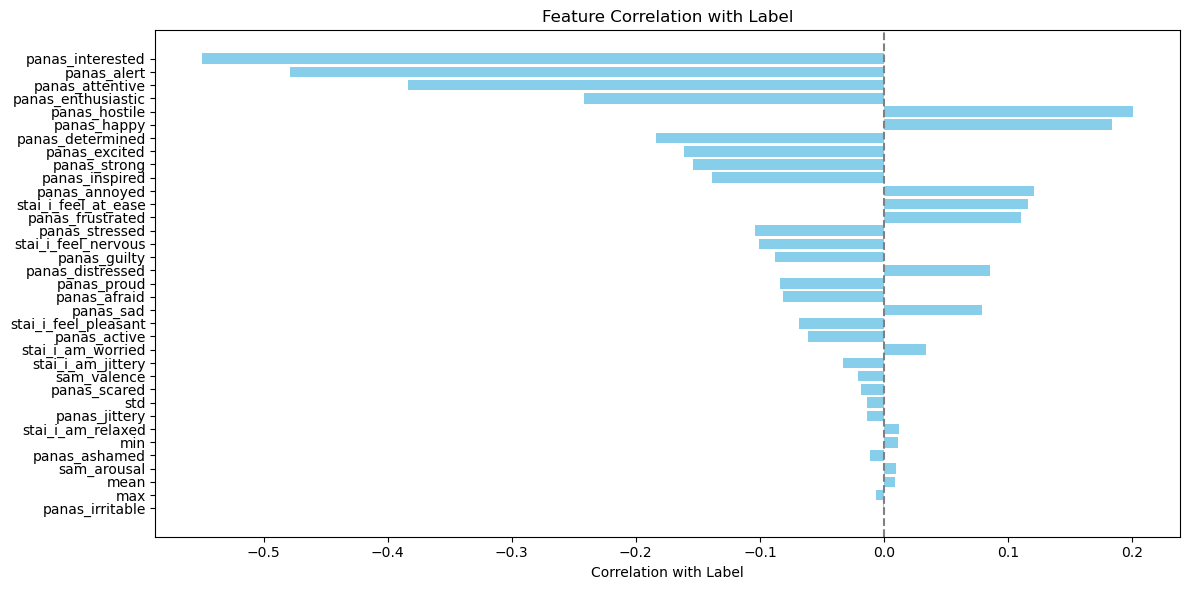

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Compute correlations
correlations = {}
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    correlations[col] = corr

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation'])
corr_df["abs_correlation"] = corr_df["correlation"].abs()
corr_df = corr_df.sort_values("abs_correlation", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(corr_df.index, corr_df["correlation"], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Correlation with Label")
plt.title("Feature Correlation with Label")
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.tight_layout()
plt.show()